In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from imblearn.datasets import fetch_datasets

In [3]:
mammography = fetch_datasets()['mammography']

In [4]:
mammography

{'data': array([[ 0.23001961,  5.0725783 , -0.27606055,  0.83244412, -0.37786573,
          0.4803223 ],
        [ 0.15549112, -0.16939038,  0.67065219, -0.85955255, -0.37786573,
         -0.94572324],
        [-0.78441482, -0.44365372,  5.6747053 , -0.85955255, -0.37786573,
         -0.94572324],
        ...,
        [ 1.2049878 ,  1.7637238 , -0.50146835,  1.5624078 ,  6.4890725 ,
          0.93129397],
        [ 0.73664398, -0.22247361, -0.05065276,  1.5096647 ,  0.53926914,
          1.3152293 ],
        [ 0.17700275, -0.19150839, -0.50146835,  1.5788636 ,  7.750705  ,
          1.5559507 ]]),
 'target': array([-1, -1, -1, ...,  1,  1,  1]),
 'DESCR': 'mammography'}

In [5]:
X = mammography['data']

In [6]:
Y = mammography['target']

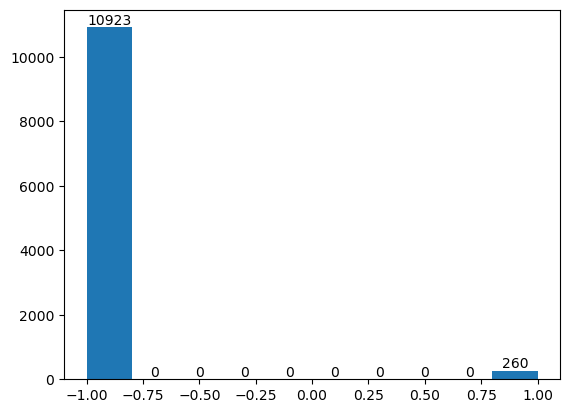

In [7]:
# proveravamo balansiranost izmedju klasa
edges, lines, bins = plt.hist(Y)
plt.bar_label(bins)
plt.show()

In [8]:
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix

In [9]:
def report(model, x, y, text='train'):
    print(f'{text}\t |\t {type(model).__name__}')
    print('-'*80)
    y_pred = model.predict(x)
    print(classification_report_imbalanced(y, y_pred))
    print('-'*80)
    print(pd.DataFrame(confusion_matrix(y, y_pred), index=['B', 'M'], columns=['B', 'M']))

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)

In [12]:
# Klasican nacin rada

In [13]:
from sklearn.tree import DecisionTreeClassifier

In [14]:
model_dtc = DecisionTreeClassifier(max_depth=6, min_samples_split=25, criterion='gini')

In [15]:
model_dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_split=25)

In [16]:
report(model_dtc, X_train, y_train)

train	 |	 DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      1.00      0.50      0.99      0.71      0.53      8192
          1       0.91      0.50      1.00      0.65      0.71      0.48       195

avg / total       0.99      0.99      0.51      0.99      0.71      0.53      8387

--------------------------------------------------------------------------------
      B   M
B  8182  10
M    97  98


In [17]:
report(model_dtc, X_test, y_test, 'test')

test	 |	 DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      1.00      0.38      0.99      0.62      0.41      2731
          1       0.68      0.38      1.00      0.49      0.62      0.36        65

avg / total       0.98      0.98      0.40      0.98      0.62      0.41      2796

--------------------------------------------------------------------------------
      B   M
B  2719  12
M    40  25


In [18]:
# RAD SA NEBALANSIRANIM KLASAMA

In [19]:
def resample(sampler, x, y):
    x_resampled, y_resampled = sampler.fit_resample(x, y)
    
    return x_resampled, y_resampled

In [20]:
from sklearn.decomposition import PCA

In [21]:
def visualize(X, X_resampled, Y, Y_resampled, x_oppacity=0.5):
    pca = PCA(n_components=2)
    
    pca.fit(X)
    
    X_pca = pca.transform(X)
    X_resampled_pca = pca.transform(X_resampled)
    
    X_stacked = [X_pca, X_resampled_pca]
    Y_stacked = [Y, Y_resampled]
    
    fig = plt.figure(figsize=(20, 5))
    
    for i in range(2):
        ax = plt.subplot(1, 2, i+1)
        colors = ['b' if y==-1 else 'r' for y in Y_stacked[i]]
        alpha = [x_oppacity if y==-1 else 1-x_oppacity for y in Y_stacked[i]]
        plt.scatter(X_stacked[i][:,0], X_stacked[i][:,1], c=colors, alpha=alpha)
        plt.title(f'{"After" if i else "Before"}', c='blue' if i else 'green')
        
    plt.show()

In [22]:
def train_and_evaluate(X_train, y_train, X_test, y_test):
    model = DecisionTreeClassifier(max_depth=7, min_samples_split=25, criterion='gini')
    model.fit(X_train, y_train)
    
    report(model, X_train, y_train)
    print()
    report(model, X_test, y_test, 'test')
    
    return model

In [23]:
# OverSampling
# RandomOverSampler

In [24]:
from imblearn.over_sampling import RandomOverSampler

In [25]:
ros = RandomOverSampler(random_state=0, sampling_strategy='minority')

In [26]:
X_resampled, y_resampled = resample(ros, X_train, y_train)

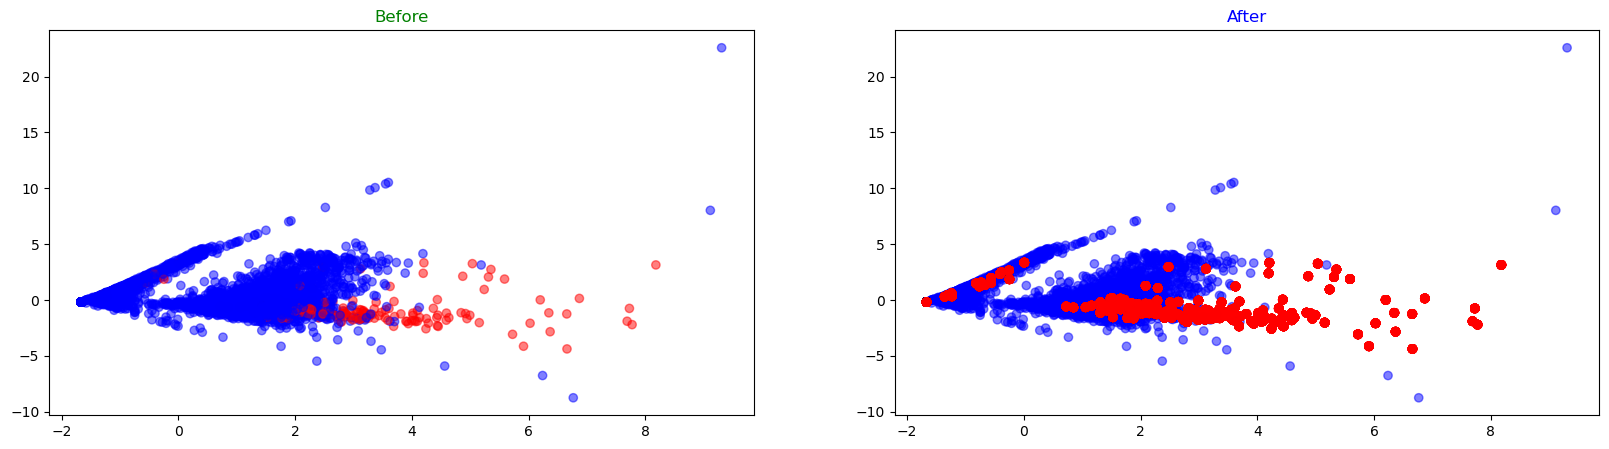

In [27]:
visualize(X_train, X_resampled, y_train, y_resampled)

In [28]:
model_ros = train_and_evaluate(X_resampled, y_resampled, X_test, y_test)

train	 |	 DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.94      0.97      0.93      0.95      0.95      0.91      8192
          1       0.97      0.93      0.97      0.95      0.95      0.90      8192

avg / total       0.95      0.95      0.95      0.95      0.95      0.91     16384

--------------------------------------------------------------------------------
      B     M
B  7941   251
M   538  7654

test	 |	 DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      0.97      0.78      0.98      0.87      0.77      2731
          1       0.38      0.78      0.97      0.51      0.87      0.75        65

avg / total       0.98      0.96      0.79      0.97      0.87 

In [29]:
# SMOTE

In [30]:
from imblearn.over_sampling import SMOTE 

In [31]:
smote = SMOTE(k_neighbors=10, random_state=42)

In [32]:
X_resampled, y_resampled = resample(smote, X_train, y_train)

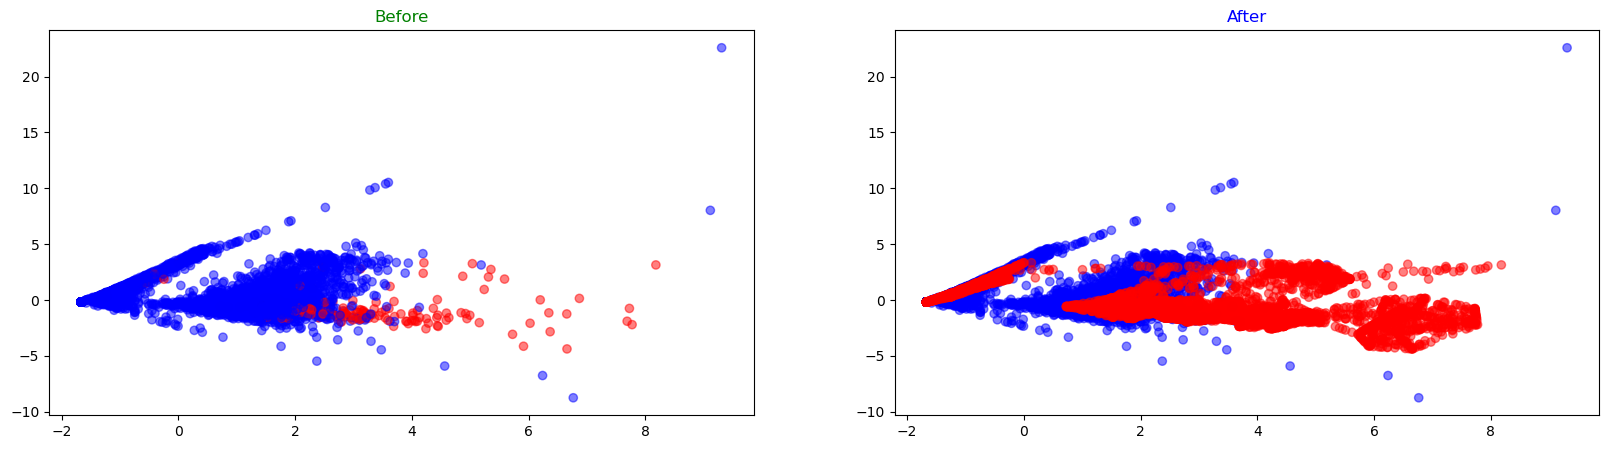

In [33]:
visualize(X_train, X_resampled, y_train, y_resampled)

In [34]:
model_smote = train_and_evaluate(X_resampled, y_resampled, X_test, y_test)

train	 |	 DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.95      0.96      0.95      0.95      0.95      0.91      8192
          1       0.96      0.95      0.96      0.95      0.95      0.91      8192

avg / total       0.95      0.95      0.95      0.95      0.95      0.91     16384

--------------------------------------------------------------------------------
      B     M
B  7862   330
M   426  7766

test	 |	 DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.96      0.83      0.98      0.89      0.80      2731
          1       0.31      0.83      0.96      0.45      0.89      0.78        65

avg / total       0.98      0.95      0.83      0.96      0.89 

In [35]:
# UnderSampling
# RandomUnderSampler

In [36]:
from imblearn.under_sampling import RandomUnderSampler

In [37]:
rus = RandomUnderSampler()

In [38]:
X_resampled, y_resampled = resample(rus, X_train, y_train)

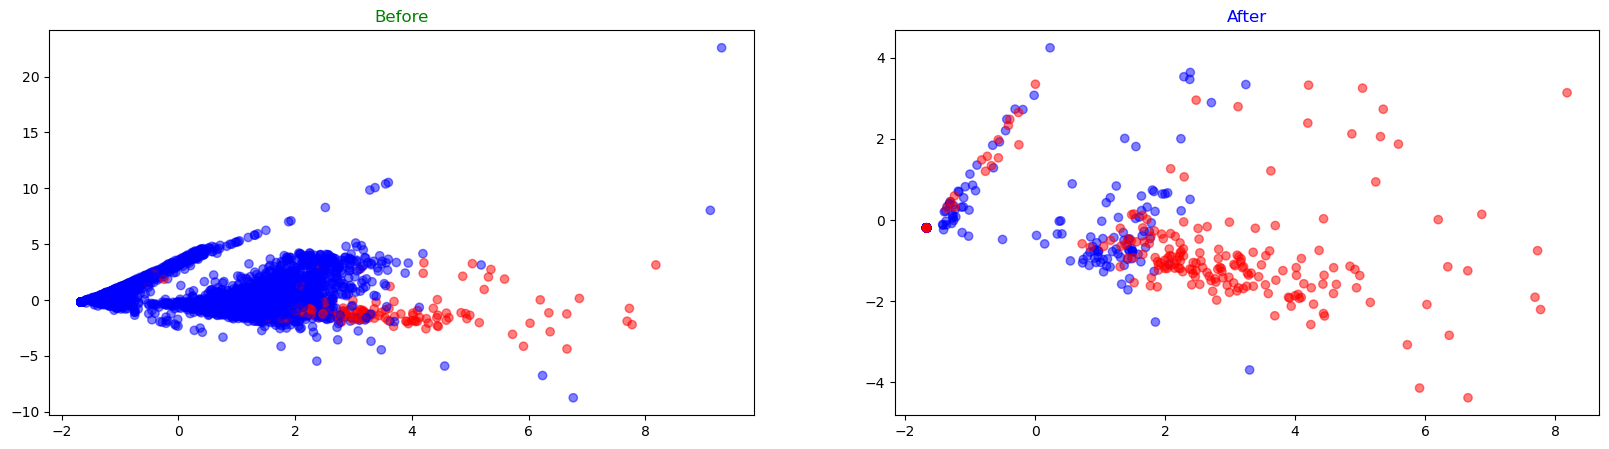

In [40]:
visualize(X_train, X_resampled, y_train, y_resampled)

In [41]:
model_rus = train_and_evaluate(X_resampled, y_resampled, X_test, y_test)

train	 |	 DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.86      0.92      0.86      0.89      0.89      0.79       195
          1       0.91      0.86      0.92      0.88      0.89      0.78       195

avg / total       0.89      0.89      0.89      0.89      0.89      0.79       390

--------------------------------------------------------------------------------
     B    M
B  179   16
M   28  167

test	 |	 DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.87      0.91      0.93      0.89      0.78      2731
          1       0.14      0.91      0.87      0.24      0.89      0.79        65

avg / total       0.98      0.87      0.91      0.91      0.89      0

In [42]:
# NearMiss

In [43]:
from imblearn.under_sampling import NearMiss

In [44]:
nm1 = NearMiss(n_neighbors=30, version=1)

In [45]:
X_resampled, y_resampled = resample(nm1, X_train, y_train)

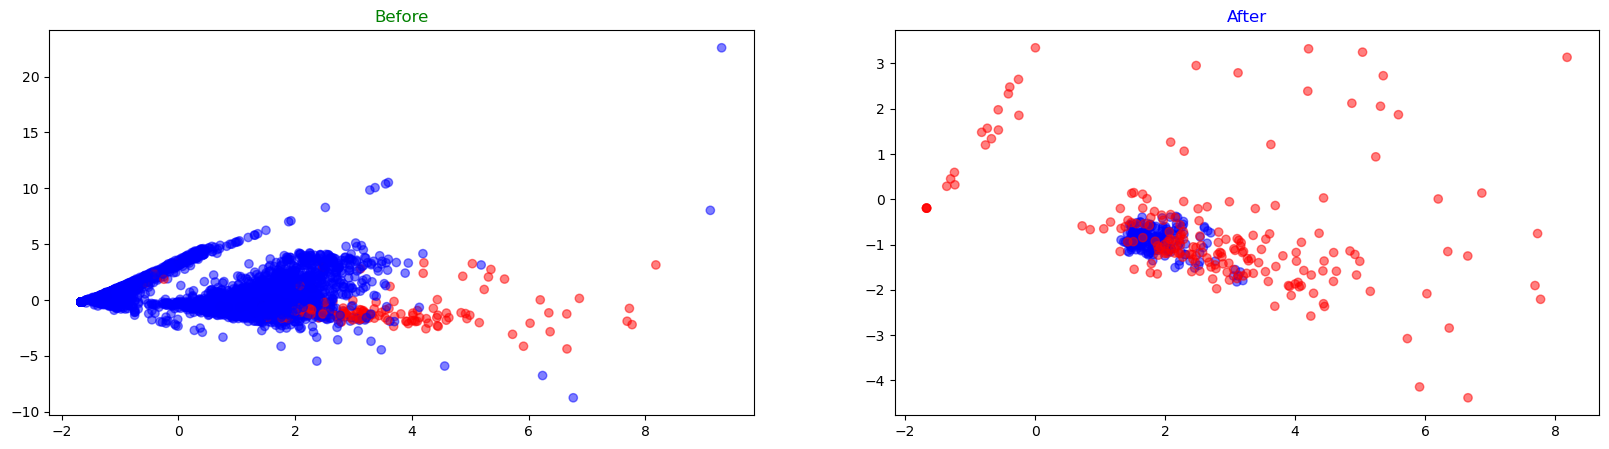

In [46]:
visualize(X_train, X_resampled, y_train, y_resampled)

In [47]:
model_nm1 = train_and_evaluate(X_resampled, y_resampled, X_test, y_test)

train	 |	 DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.92      0.95      0.91      0.93      0.93      0.87       195
          1       0.95      0.91      0.95      0.93      0.93      0.87       195

avg / total       0.93      0.93      0.93      0.93      0.93      0.87       390

--------------------------------------------------------------------------------
     B    M
B  186    9
M   17  178

test	 |	 DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.96      0.08      0.86      0.14      0.26      0.06      2731
          1       0.02      0.86      0.08      0.04      0.26      0.07        65

avg / total       0.94      0.10      0.84      0.14      0.26      0

In [48]:
nm2 = NearMiss(n_neighbors=30, version=2)

In [49]:
X_resampled, y_resampled = resample(nm2, X_train, y_train)

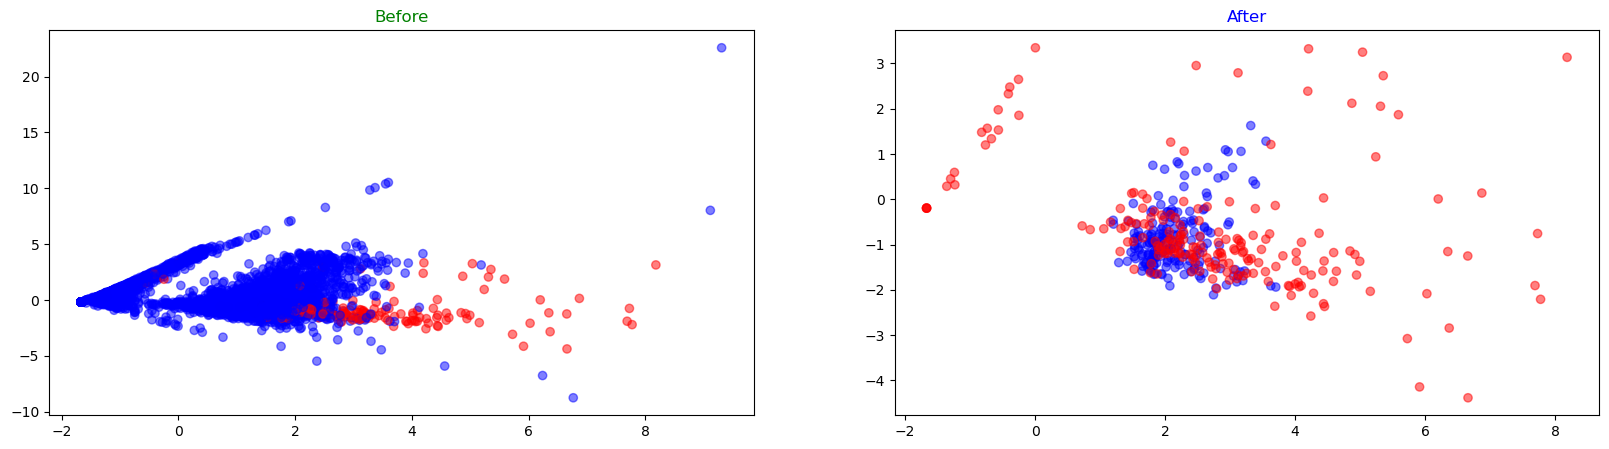

In [50]:
visualize(X_train, X_resampled, y_train, y_resampled)

In [52]:
model_nm2 = train_and_evaluate(X_resampled, y_resampled, X_test, y_test)

train	 |	 DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.91      0.99      0.90      0.95      0.94      0.90       195
          1       0.99      0.90      0.99      0.94      0.94      0.88       195

avg / total       0.95      0.94      0.94      0.94      0.94      0.89       390

--------------------------------------------------------------------------------
     B    M
B  193    2
M   20  175

test	 |	 DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.88      0.04      0.80      0.07      0.17      0.03      2731
          1       0.02      0.80      0.04      0.04      0.17      0.03        65

avg / total       0.86      0.05      0.78      0.07      0.17      0

In [53]:
nm3 = NearMiss(n_neighbors=30, version=3)

In [54]:
X_resampled, y_resampled = resample(nm3, X_train, y_train)

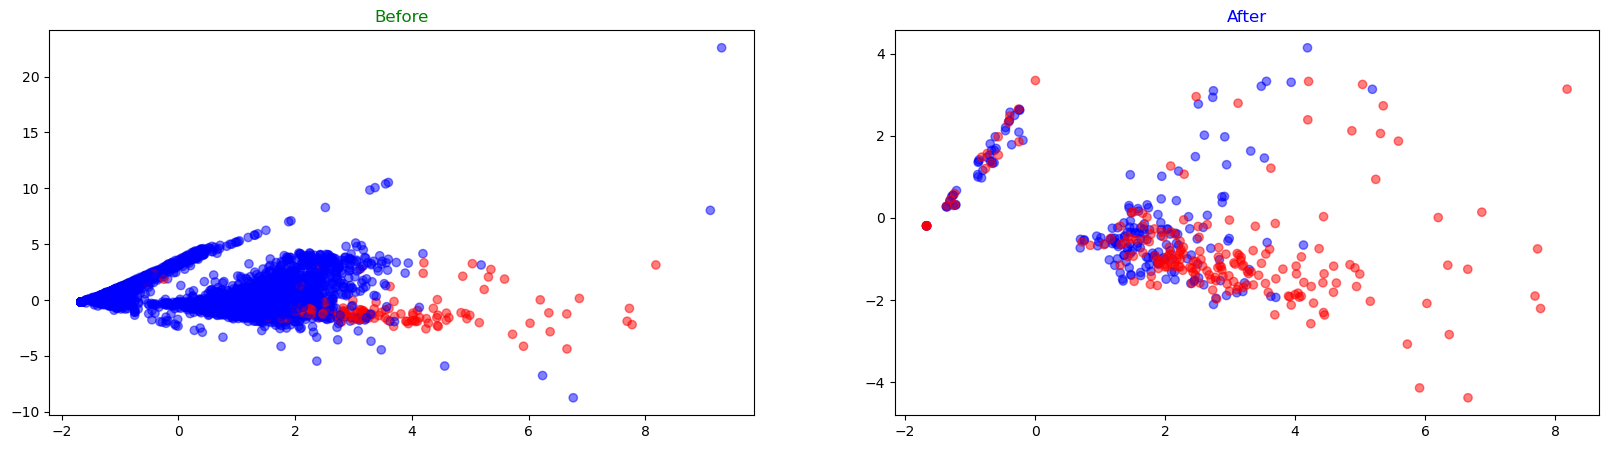

In [55]:
visualize(X_train, X_resampled, y_train, y_resampled)

In [56]:
model_nm3 = train_and_evaluate(X_resampled, y_resampled, X_test, y_test)

train	 |	 DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.79      0.94      0.75      0.86      0.84      0.72       195
          1       0.92      0.75      0.94      0.83      0.84      0.69       195

avg / total       0.86      0.84      0.84      0.84      0.84      0.70       390

--------------------------------------------------------------------------------
     B    M
B  183   12
M   49  146

test	 |	 DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      0.62      0.66      0.76      0.64      0.41      2731
          1       0.04      0.66      0.62      0.08      0.64      0.41        65

avg / total       0.97      0.63      0.66      0.75      0.64      0

In [57]:
from imblearn.under_sampling import CondensedNearestNeighbour

In [58]:
cnn = CondensedNearestNeighbour(random_state=0, n_neighbors=10, sampling_strategy='majority')

In [59]:
X_resampled, y_resampled = resample(cnn, X_train, y_train)

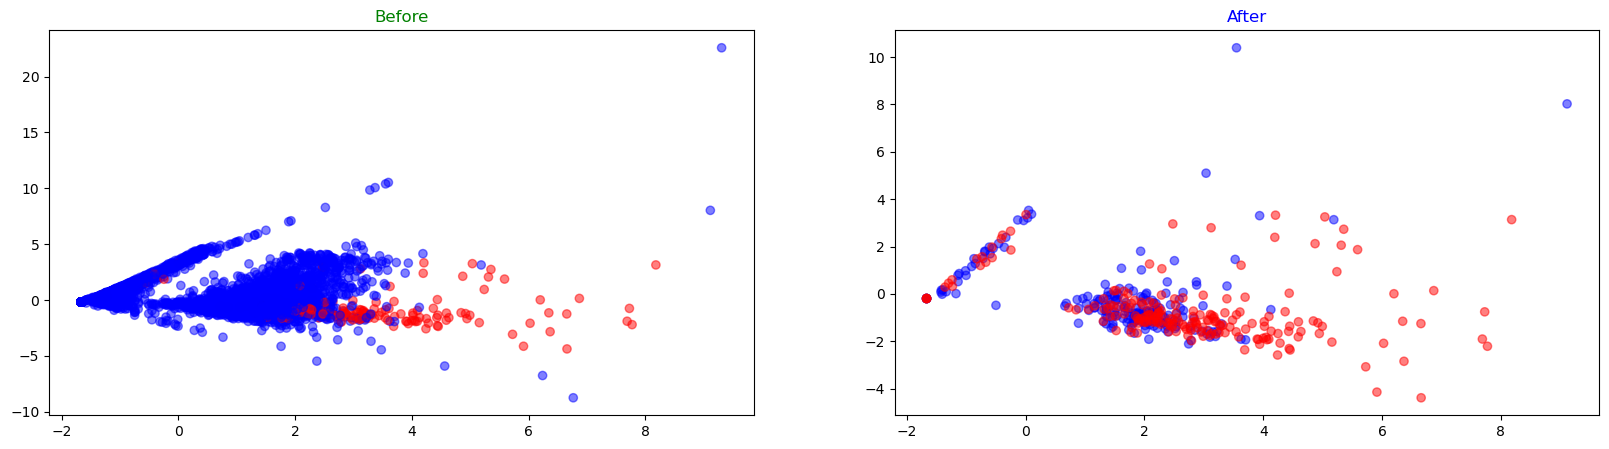

In [60]:
visualize(X_train, X_resampled, y_train, y_resampled)

In [61]:
model_cnn = train_and_evaluate(X_resampled, y_resampled, X_test, y_test)

train	 |	 DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.86      0.80      0.87      0.83      0.83      0.69       193
          1       0.82      0.87      0.80      0.84      0.83      0.70       195

avg / total       0.84      0.84      0.83      0.83      0.83      0.70       388

--------------------------------------------------------------------------------
     B    M
B  155   38
M   26  169

test	 |	 DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      0.56      0.83      0.72      0.68      0.45      2731
          1       0.04      0.83      0.56      0.08      0.68      0.48        65

avg / total       0.97      0.57      0.82      0.70      0.68      0

In [62]:
from imblearn.combine import SMOTEENN

In [63]:
smoteenn = SMOTEENN(random_state=42, sampling_strategy='auto')

In [64]:
X_resampled, y_resampled = resample(smoteenn, X_train, y_train)

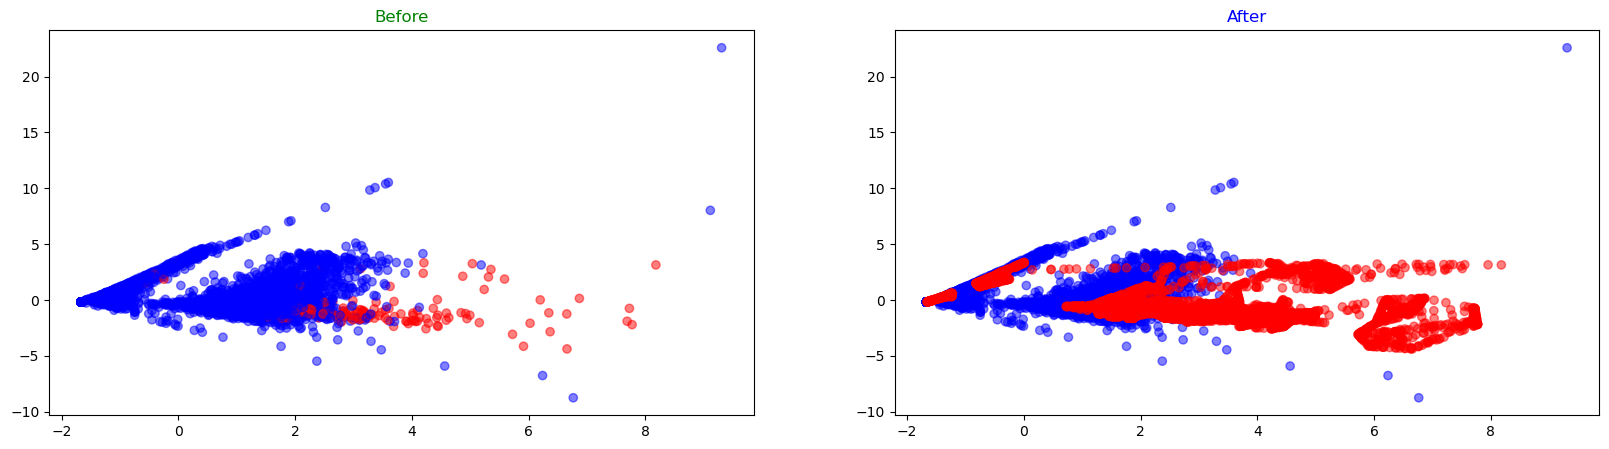

In [65]:
visualize(X_train, X_resampled, y_train, y_resampled)

In [66]:
model_smoteenn = train_and_evaluate(X_resampled, y_resampled, X_test, y_test)

train	 |	 DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.98      0.98      0.98      0.98      0.98      0.96      7722
          1       0.98      0.98      0.98      0.98      0.98      0.96      7926

avg / total       0.98      0.98      0.98      0.98      0.98      0.96     15648

--------------------------------------------------------------------------------
      B     M
B  7574   148
M   187  7739

test	 |	 DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.96      0.85      0.98      0.90      0.82      2731
          1       0.31      0.85      0.96      0.46      0.90      0.80        65

avg / total       0.98      0.95      0.85      0.96      0.90 

In [67]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [74]:
model_ens = BalancedRandomForestClassifier(max_depth=6, random_state=42, max_samples=20)

In [75]:
model_ens.fit(X_train, y_train)

/home/natasa/anaconda3/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/natasa/anaconda3/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/natasa/anaconda3/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour

BalancedRandomForestClassifier(max_depth=6, max_samples=20, random_state=42)

In [76]:
report(model_ens, X_train, y_train)

train	 |	 BalancedRandomForestClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.89      0.87      0.94      0.88      0.77      8192
          1       0.16      0.87      0.89      0.27      0.88      0.77       195

avg / total       0.98      0.89      0.87      0.92      0.88      0.77      8387

--------------------------------------------------------------------------------
      B    M
B  7288  904
M    26  169


In [77]:
report(model_ens, X_test, y_test, 'test')

test	 |	 BalancedRandomForestClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.89      0.94      0.94      0.92      0.84      2731
          1       0.17      0.94      0.89      0.29      0.92      0.84        65

avg / total       0.98      0.90      0.94      0.93      0.92      0.84      2796

--------------------------------------------------------------------------------
      B    M
B  2443  288
M     4   61


In [72]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [78]:
models = [model_dtc, model_ros, model_smote, model_rus, model_nm1, model_nm2, model_nm3, model_cnn,
         model_smoteenn, model_ens]

In [79]:
model_names = ['DTC', 'ROS', 'SMOTE', 'RUS', 'NM1', 'NM2', 'NM3', 'CNN', 'SMOTEENN', 'ENS']

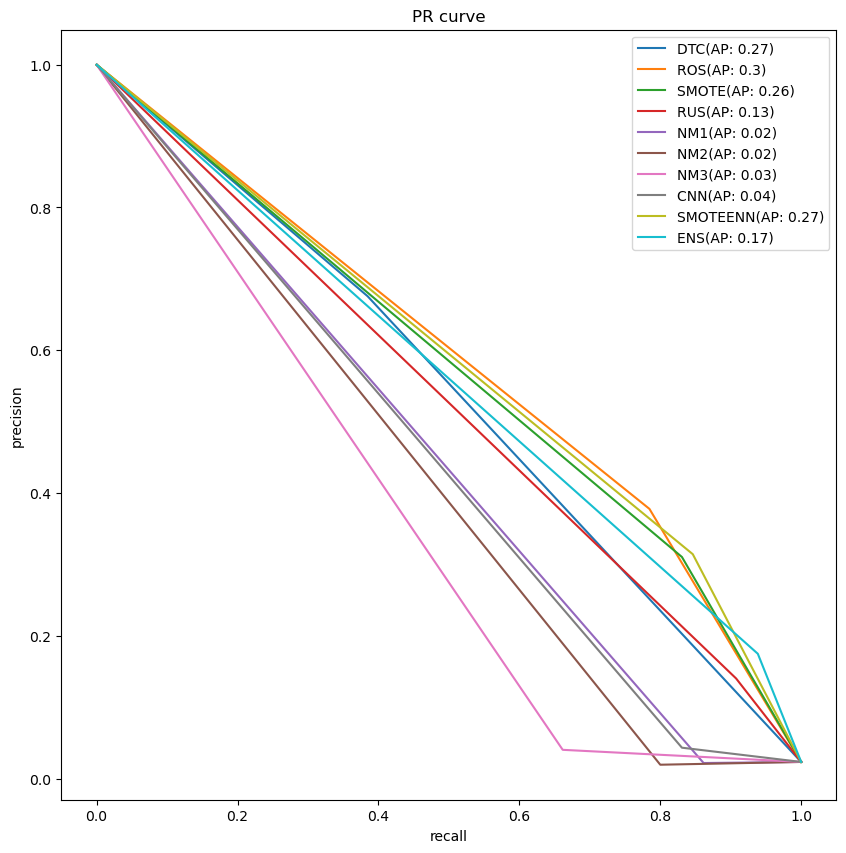

In [80]:
plt.figure(figsize=(10,10))

for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    
    ap = average_precision_score(y_test, y_pred)
    lab = model_name + "(AP: " + str(round(ap,2)) + ")"
    plt.plot(recall, precision, label=lab)
    
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PR curve')
plt.legend()
plt.show()

In [81]:
from sklearn.metrics import roc_curve, roc_auc_score

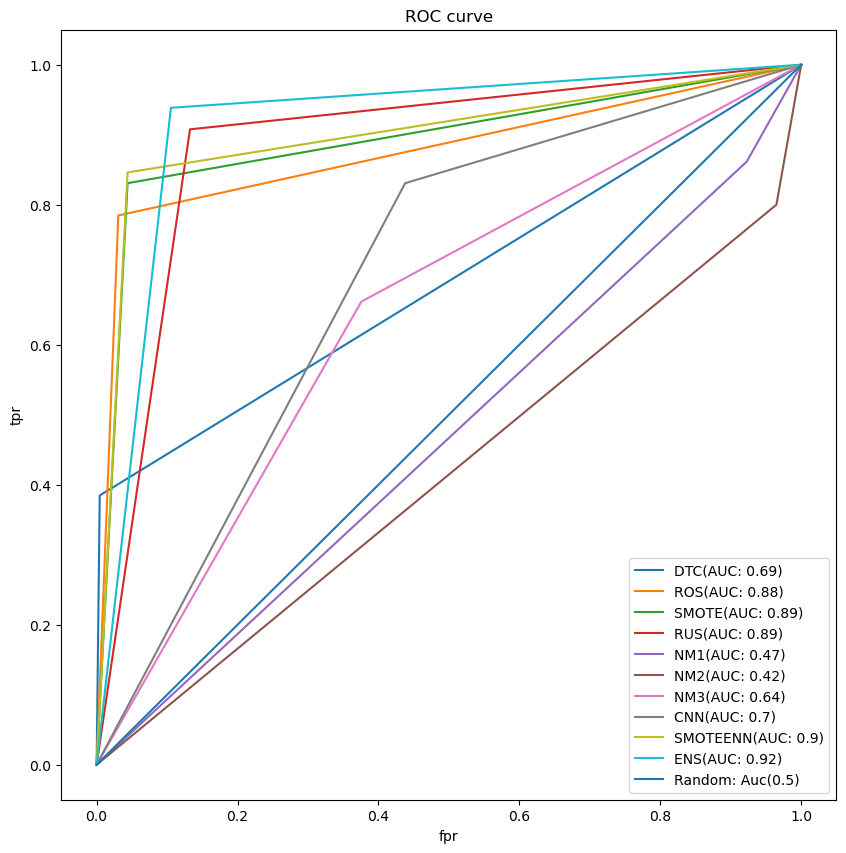

In [82]:
plt.figure(figsize=(10,10))

for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    
    auc = roc_auc_score(y_test, y_pred)
    lab = model_name + "(AUC: " + str(round(auc, 2)) + ")"
    plt.plot(fpr, tpr, label=lab)
    
plt.plot([0,1], [0,1], label="Random: Auc(0.5)")
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.legend()
plt.show()